In [42]:
%reload_ext autoreload
%autoreload 2

import torch.nn.functional as F
from datasets import load_dataset
from pytorch_lightning import LightningModule
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from models.conditional_unet import Unet
from utils.img_utils import *


In [59]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


timesteps = 200

# define beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)
    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze(0))
    return noisy_image


def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    # 先采样噪声
    if noise is None:
        noise = torch.randn_like(x_start)

    # 用采样得到的噪声去加噪图片
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    # 根据加噪了的图片去预测采样的噪声
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)

    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [46]:
dataset = load_dataset('fashion_mnist')


Found cached dataset fashion_mnist (C:/Users/82716/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
print(dataset)
tr_set = dataset['train']
print(tr_set)

img_size = 128
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(.5, .5)
])

reverse_transform = transforms.Compose([
    transforms.Normalize(-1, 2),
    transforms.ToPILImage()
])

dataset.with_transform(transform)
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


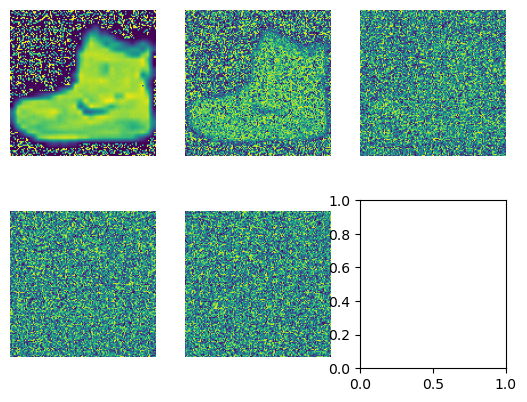

In [60]:

image, labels = tr_set[0].values()
print(image, labels)
show_img(image)

show_img(transform(image), transpose=True)

x_start = transform(image).unsqueeze(0)
print(x_start.shape)
rev_image = reverse_transform(x_start.squeeze(0))
show_img(rev_image)

show_imgs(*[get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]], row=2)

In [ ]:
print(dataset)
print(tr_set)

In [33]:

# load dataset from the hub
# dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]

    return examples


transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
print(batch.keys())


Found cached dataset fashion_mnist (C:/Users/82716/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['pixel_values'])


In [35]:
from pathlib import Path


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


results_folder = Path("../results")
results_folder.mkdir(exist_ok=True)
save_and_sample_every = 1000

In [36]:
from torch.optim import Adam


class DiffusionLitModule(LightningModule):
    def __init__(self, lr, timesteps=1000, batch_size=32, image_size=128, channels=1):
        super().__init__()
        self.save_hyperparameters()

        self.dataset = load_dataset('fashion_mnist')

        self.model = Unet(
            dim=image_size,
            channels=channels,
        )

    def forward(self, x, t):
        return self.model(x, t)

    def training_step(self, batch, batch_idx):
        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"]

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device).long()

        loss = p_losses(self.model, batch, t, loss_type="huber")

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def on_train_epoch_end(self, outputs):
        if self.current_epoch % save_and_sample_every == 0:
            imgs = sample(self.model, self.image_size, self.batch_size, self.channels)
            save_image(imgs, self.current_epoch, results_folder)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [37]:
epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        # save generated images
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow=6)

Loss: 0.44601547718048096
Loss: 0.1267276108264923
Loss: 0.06714068353176117
Loss: 0.05282481759786606
Loss: 0.05024003982543945
Loss: 0.04816766455769539
Loss: 0.03816492483019829
Loss: 0.05166769400238991
Loss: 0.05162100866436958
Loss: 0.04257306084036827
Loss: 0.04078337922692299
Loss: 0.0453205406665802
Loss: 0.04216369241476059
Loss: 0.038353193551301956
Loss: 0.05237238109111786
Loss: 0.041446566581726074
Loss: 0.037928756326436996
Loss: 0.03931943327188492
Loss: 0.03953380137681961
Loss: 0.03937783092260361
Loss: 0.03406275063753128
Loss: 0.04154616966843605
Loss: 0.030833184719085693
Loss: 0.03408699855208397
Loss: 0.035665806382894516


sampling loop time step: 100%|██████████| 200/200 [00:04<00:00, 49.10it/s]


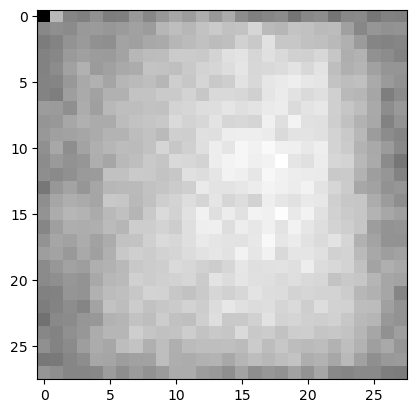

In [38]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")
